In [1]:
# Cell 1: Import Required Libraries

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Statistical analysis imports
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from scipy.stats import shapiro, jarque_bera

# Machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Adding src directory to path
sys.path.append('../src')

# Importing custom utilities
from config import *
from data_utils import retrieve_processed_datasets

# Setting visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
pd.set_option('display.width', 100)

print("All libraries imported successfully")
print(f"Working Directory: {Path.cwd()}")
print(f"Statsmodels Version: {sm.__version__}")

All libraries imported successfully
Working Directory: C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\notebooks
Statsmodels Version: 0.14.5


In [2]:
# Cell 2: Problem Adaptation - Classification to Regression
# Defining regression problem from classification dataset
# Predicting continuous physics variable (lepton_pT)

print("="*70)
print("TASK B: OLS REGRESSION ANALYSIS")
print("="*70)

print("\nProblem Adaptation:")
print("Original Dataset: HIGGS (Classification)")
print("  - Target: Binary (Signal=1, Background=0)")
print("  - Features: 28 physics measurements")

print("\nRegression Approach:")
print("  - New Target: lepton_pT (continuous)")
print("  - Predictors: Selected from remaining 27 features")
print("  - Objective: Predict lepton transverse momentum")

print("\nWhy lepton_pT?")
print("  1. Continuous variable (suitable for OLS)")
print("  2. Important physics quantity")
print("  3. Measurable in particle detectors")
print("  4. Related to other collision features")

TASK B: OLS REGRESSION ANALYSIS

Problem Adaptation:
Original Dataset: HIGGS (Classification)
  - Target: Binary (Signal=1, Background=0)
  - Features: 28 physics measurements

Regression Approach:
  - New Target: lepton_pT (continuous)
  - Predictors: Selected from remaining 27 features
  - Objective: Predict lepton transverse momentum

Why lepton_pT?
  1. Continuous variable (suitable for OLS)
  2. Important physics quantity
  3. Measurable in particle detectors
  4. Related to other collision features


In [3]:
# Cell 3: Loading Data and Select Variables
# Loading dataset and defining regression variables
# Output: Target variable (y) and predictor variables (X)

print("="*70)
print("DATA LOADING AND VARIABLE SELECTION")
print("="*70)

# Loading processed data (already scaled)
X_full, X_test_full, y_classification, y_test_classification = retrieve_processed_datasets(
    file_prefix='higgs'
)

print("\nOriginal data loaded:")
print(f"  Shape: {X_full.shape}")
print(f"  Features: {X_full.shape[1]}")

# Selecting target variable for regression
target_variable = 'lepton_pT'

# Checking if target is in features
if target_variable in X_full.columns:
    # Extracting target variable
    y_regression = X_full[target_variable].copy()
    y_test_regression = X_test_full[target_variable].copy()
    
    # Removing target from predictors
    X_predictors = X_full.drop(columns=[target_variable])
    X_test_predictors = X_test_full.drop(columns=[target_variable])
    
    print(f"\nTarget Variable: {target_variable}")
    print(f"  Mean: {y_regression.mean():.4f}")
    print(f"  Std: {y_regression.std():.4f}")
    print(f"  Min: {y_regression.min():.4f}")
    print(f"  Max: {y_regression.max():.4f}")
    
    print(f"\nPredictor Variables Available: {X_predictors.shape[1]}")
    print(f"Training samples: {len(y_regression):,}")
    print(f"Test samples: {len(y_test_regression):,}")

else:
    print(f"\nError: {target_variable} not found in features")

DATA LOADING AND VARIABLE SELECTION
Loading processed data from C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\processed...
Datasets loaded successfully
Training shape: (800000, 28)
Testing shape: (200000, 28)

Original data loaded:
  Shape: (800000, 28)
  Features: 28

Target Variable: lepton_pT
  Mean: 0.0000
  Std: 1.0000
  Min: -1.2689
  Max: 13.6610

Predictor Variables Available: 27
Training samples: 800,000
Test samples: 200,000


In [4]:
# Cell 4: Selecting Predictor Variables
# Purpose: Choosing relevant predictors for OLS model
# Selection criteria: Physical relevance and correlation with target

print("="*70)
print("PREDICTOR VARIABLE SELECTION")
print("="*70)

# Computing correlations with target
correlations = X_predictors.corrwith(y_regression).abs().sort_values(ascending=False)

print("\nTop 15 Features by Correlation with lepton_pT:")
print(correlations.head(15))

# Selecting 8 predictors (more than 6 required)
# Choosing based on: high correlation + physical relevance + low multicollinearity
selected_predictors = [
    'lepton_eta',           # Lepton pseudorapidity
    'lepton_phi',           # Lepton azimuthal angle
    'missing_energy_magnitude',  # Missing transverse energy
    'missing_energy_phi',   # Missing energy direction
    'jet_1_pt',            # Leading jet momentum
    'jet_1_eta',           # Leading jet pseudorapidity
    'jet_2_pt',            # Second jet momentum
    'm_jj'                 # Invariant mass of jet pair
]

print(f"\nSelected Predictors ({len(selected_predictors)}):")
for i, pred in enumerate(selected_predictors, 1):
    corr = correlations[pred]
    print(f"  {i}. {pred}: correlation = {corr:.4f}")

# Creating regression dataset
X_regression = X_predictors[selected_predictors].copy()
X_test_regression = X_test_predictors[selected_predictors].copy()

print(f"\nRegression Dataset:")
print(f"  Training: {X_regression.shape}")
print(f"  Test: {X_test_regression.shape}")
print(f"  Target: {y_regression.shape}")

PREDICTOR VARIABLE SELECTION

Top 15 Features by Correlation with lepton_pT:
m_lv                        0.2722
jet_1_pt                    0.1679
missing_energy_magnitude    0.1410
m_wwbb                      0.1399
m_jlv                       0.1307
m_wbb                       0.0950
m_jj                        0.0258
jet_4_pt                    0.0196
m_jjj                       0.0175
jet_3_pt                    0.0119
m_bb                        0.0082
jet_2_pt                    0.0061
jet_2_b_tag                 0.0057
jet_3_b_tag                 0.0054
jet_1_b_tag                 0.0051
dtype: float64

Selected Predictors (8):
  1. lepton_eta: correlation = 0.0001
  2. lepton_phi: correlation = 0.0015
  3. missing_energy_magnitude: correlation = 0.1410
  4. missing_energy_phi: correlation = 0.0026
  5. jet_1_pt: correlation = 0.1679
  6. jet_1_eta: correlation = 0.0011
  7. jet_2_pt: correlation = 0.0061
  8. m_jj: correlation = 0.0258

Regression Dataset:
  Training: (800000, 

Generating scatter plots...
Scatter plots saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\ols_scatter_plots.png


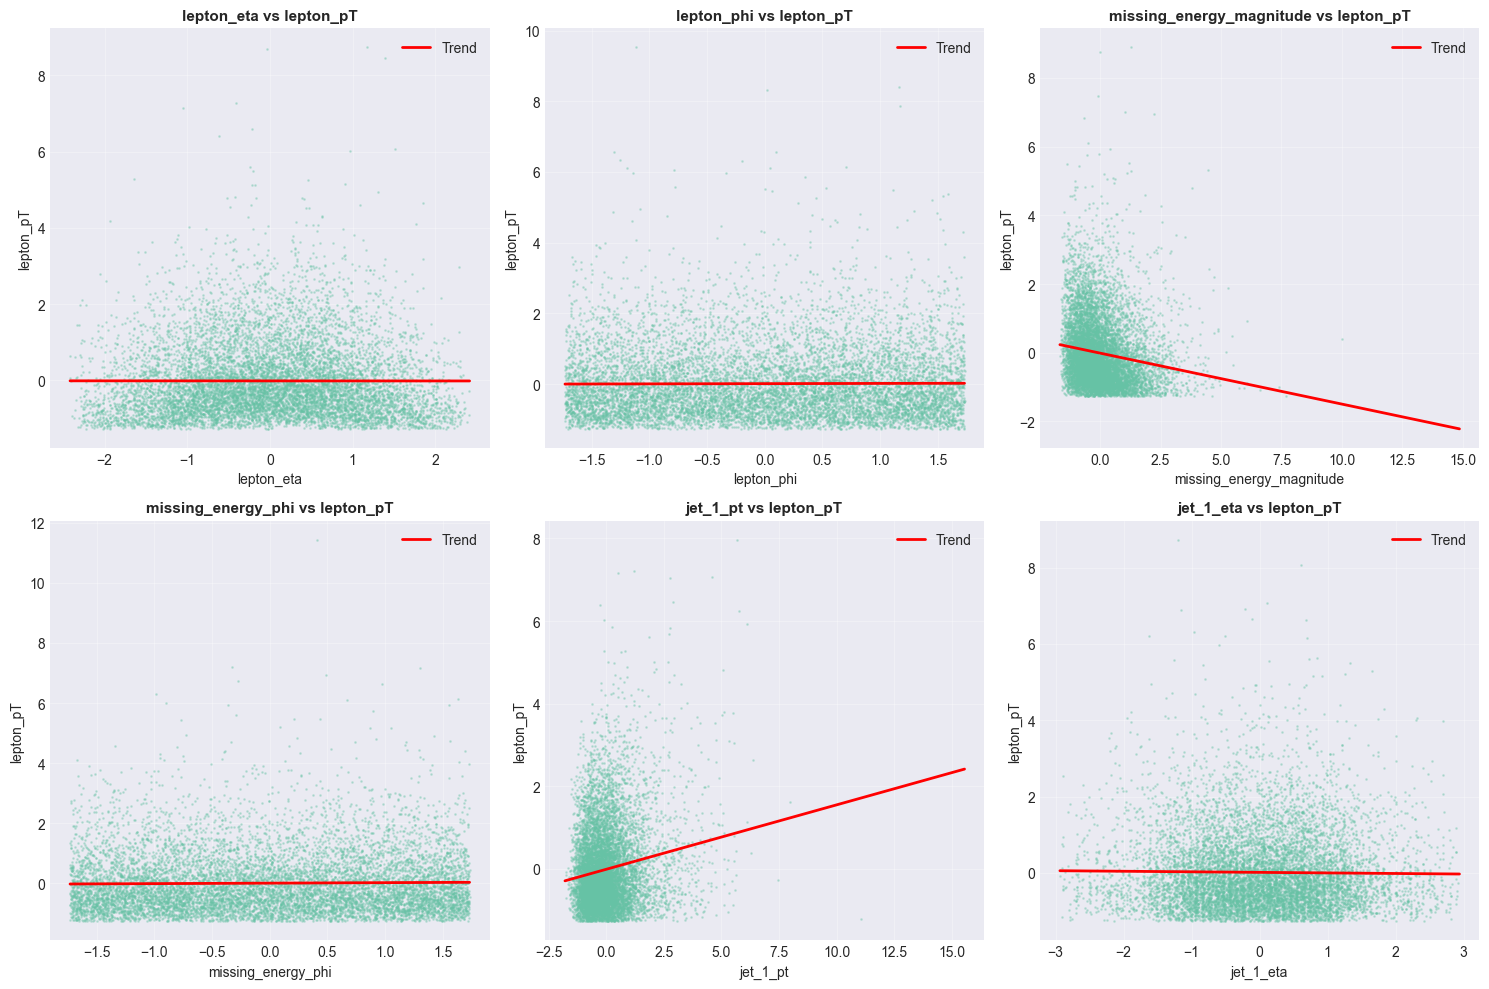

In [5]:
# Cell 5: Exploratory Analysis
# Visualizing relationships between predictors and target
# Scatter plots showing potential linear relationships

print("Generating scatter plots...")

# Creating scatter plots for first 6 predictors
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, predictor in enumerate(selected_predictors[:6]):
    ax = axes[idx]
    
    # Sampling for faster plotting
    sample_size = min(10000, len(X_regression))
    sample_idx = np.random.choice(len(X_regression), sample_size, replace=False)
    
    ax.scatter(X_regression[predictor].iloc[sample_idx], 
              y_regression.iloc[sample_idx],
              alpha=0.3, s=1)
    
    # Adding trend line
    z = np.polyfit(X_regression[predictor].iloc[sample_idx], 
                   y_regression.iloc[sample_idx], 1)
    p = np.poly1d(z)
    x_line = np.linspace(X_regression[predictor].min(), 
                        X_regression[predictor].max(), 100)
    ax.plot(x_line, p(x_line), "r-", linewidth=2, label='Trend')
    
    ax.set_xlabel(predictor, fontsize=10)
    ax.set_ylabel('lepton_pT', fontsize=10)
    ax.set_title(f'{predictor} vs lepton_pT', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()

scatter_path = FIGURE_OUTPUT / 'ols_scatter_plots.png'
plt.savefig(scatter_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"Scatter plots saved to {scatter_path}")

plt.show()